# Figure 7: (Analysis similar to Figure 6)

##### This notebook reproduces the distance measurement for asteroid 4953/1990 (hereafter 4953) MU using real-time observations from the PROMPT telescope in Chile, corresponding to Figure 7 and Table 1 (column 3) of the manuscript. The procedure begins by importing the real-time astrometric RA data, as shown in Table 3, and fitting Equation 1, since the observations span only a single night of ~ 7 hours. The resulting distance is then converted to astronomical units and compared against the NASA JPL Horizons reference value for validation.

##### To reproduce Figure 5 (right panel), columns 3 and 8 of the csv file “Figure 7 and Table 1 (4953).csv”, located in the GitHub folder “Figures 5–7, Tables 1–3”, are used. Additionally, the RA and DEC values of the Horizons ephemeris are matched to the nearest corresponding timestamps of the real-time observations.

##### Step 1: Here we import all the packages used throughout the notebook:

In [1]:
# For numerical arrays and dataframes.
import numpy as np
import pandas as pd

# For handling plotting and axis formatting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Tools for fitting functions to data
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit

# For file handling and regular expressions
import re
import os

# For custom subplot layouts
from matplotlib.gridspec import GridSpec

# Access to trigonometric functions and constants.
import math

##### Step 2: Reading the entire csv file of asteroid 4953

In [2]:
file_path = 'Figure 7 and Table 1 (4953).csv'
data = pd.read_csv(file_path)
print(data.to_string(index=False))

 Adjusted JD (Spline)   Interpolated RA (Spline)
             0.000000                  10.864322
             0.039598                  10.842719
             0.079196                  10.821097
             0.118795                  10.799487
             0.158393                  10.777918
             0.197991                  10.756420
             0.237589                  10.735022
             0.277187                  10.713754


##### Step 3: Printing the time and RA data needed for the topocentric parallax analysis. 

In [3]:
# Subtracting the minimum in the time column to make the first observation start at 0
jd_adjusted = data['Adjusted JD (Spline)']
jd_binned_median = jd_adjusted - jd_adjusted.min()

# Extracting the RA values
ra_deg_adjusted_detected = data[' Interpolated RA (Spline)']

print(f"{'JD Adjusted':<25}{'RA Adjusted Detected':<25}")
print("=" * 75)

for jd, ra in zip(jd_binned_median, ra_deg_adjusted_detected):
    print(f"{jd:<25.10f}{ra:<25.10f}")

JD Adjusted              RA Adjusted Detected     
0.0000000000             10.8643220000            
0.0395980000             10.8427190000            
0.0791960000             10.8210970000            
0.1187950000             10.7994870000            
0.1583930000             10.7779180000            
0.1979910000             10.7564200000            
0.2375890000             10.7350220000            
0.2771870000             10.7137540000            


##### Step 4: Equation 1 in Maryann et al. 2025

In [4]:
# Equation 1 --> Am * sin(2πx + B) + Cx + D as defined in the paper. 
# We use only the linear form of the model since the observations of 4953 span only a single night. 
# Sinusoidal term --> Am * sin(2πx + B) represents the effect of Earth's rotation (x = time; Am = amplitude of the signal, also referred to as the parallax amplitude; B = phase shift).
# Linear term --> C * x + D represents the asteroid’s linear motion (C * x corresponds to the asteroid’s constant angular velocity; D is the RA offset).
# fit_function_linear defines the Python implementation of Equation 1.
    
def fit_function_linear(x, A, B, C, D):
    return A * np.sin(2 * np.pi * x + B) + C * x + D

# Fits the linear model to normalized RA as a function of normalized time.
# curve_fit() from scipy.optimize performs a least-squares fit, determining the best-fit values of Am, B, C, and D that reproduce the RA data, assuming 20 mas noise.
# params_sine:     is a NumPy array containing the best-fit parameter values.
# covariance_sine: is the 4×4 covariance matrix describing the uncertainties and correlations among Am, B, C, and D.
    
params_sine, covariance_sine = curve_fit(fit_function_linear, jd_binned_median, ra_deg_adjusted_detected)
print(f"\033[1;32m Equation 1: sine +linear terms (Paramters):     {params_sine}\033[0m")

# Uncertainties associated with Equation 1.
# These are required for understanding error propagation.

# np.diag(covariance_sine): extracts the variances of Am, B, C, and D.
# np.sqrt(...):             converts the variances into 1σ standard deviations.

sine_uncertainties = np.sqrt(np.diag(covariance_sine))
print(f"\033[1;32m Equation 1: sine +linear terms (Uncertainities):{sine_uncertainties}\033[0m")

 Equation 1: sine +linear terms (Paramters):     [-2.23609146e-03 -6.70800116e+00 -5.32068397e-01  1.08633988e+01]
 Equation 1: sine +linear terms (Uncertainities):[4.83756697e-05 1.08657567e-02 3.05183431e-04 4.29121693e-05]


##### Step 5: The parallax amplitude and uncertainty from the asteroids linear fit

In [5]:
# We read only the parallax amplitude and its uncertainty, and convert to radians. 
# A closer asteroid  → larger sinusoidal amplitude
# A farther asteroid → smaller sinusoidal amplitude

amplitude_deg = params_sine[0]
amplitude_rad = math.radians(amplitude_deg)
print(f"\033[1;32mamplitude (rad):              {amplitude_rad}\033[0m")

amplitude_uncertainty_deg = sine_uncertainties[0]
amplitude_uncertainty_rad = math.radians(amplitude_uncertainty_deg)
print(f"\033[1;32mamplitude uncertianity (rad): {amplitude_uncertainty_rad}\033[0m")

amplitude (rad):              -3.9027158402455246e-05
amplitude uncertianity (rad): 8.443147148413888e-07


##### Step 6: Equation 4 in Maryann et al. 2025 (Distance measurement with respect to the center of the Earth)

In [6]:
earth_radius_km = 6371  # in km

# Distance measurement concerning the center of the Earth.
distance_km = earth_radius_km / amplitude_rad

# Compute distance uncertainty
distance_uncertainty_km = (earth_radius_km/amplitude_rad) * (amplitude_uncertainty_rad/abs(amplitude_rad))

print(f"\033[1;32mEquation 4: Distance_km: {abs(distance_km):.2f} ± {abs(distance_uncertainty_km):.2f}\033[0m")

Equation 4: Distance_km: 163245295.35 ± 3531653.61


##### Step 7: Latitude of the Observatory (Correction 1)

##### Note: The PROMPT latitude used in the published manuscript (30.1732° S) differs slightly from the precise latitude reported by the Skynet Robotic Telescope Network linked below (−30.168°). The code released here uses the Skynet value. This difference has a negligible effect on the topocentric parallax calculation and does not affect any results or conclusions in the paper. 

In [7]:
# The observatory taking the observations of asteroid 4953 is the PROMPT telescope in Chile. 
# The observatory is in the southern hemisphere of the Earth at a latitude of 30.168° S. 
# We convert the latitude in degrees to radians. 
# The details for the observatory position are taken from the Skynet Robotic Telescope Network website, noted as follows: 
# https://skynet.unc.edu/sites/view?id=2 
# LATITUDE:	-30.168 degrees, LONGITUDE:	-70.805 degrees, ELEVATION:	2286 meters

latitude_deg = 30.168
latitude_rad = math.radians(latitude_deg)
print("Latitude (rad):              ", latitude_rad)

Latitude (rad):               0.5265309287416493


##### Step 8: Declination (DEC) of the observations (Correction 2)

In [8]:
# Since the DEC of the observations is over a single night, the change in DEC is very small, and so, we assume a single DEC value fixed at the first observation.
dec_deg = 36.743048
dec_rad = math.radians(dec_deg)
print("DEC (rad):                   ", dec_rad)

DEC (rad):                    0.6412871648183175


##### Step 9: Equation 3 in Maryann et al. 2025

In [9]:
# We correct for the distance measurement in step 6 with the latitude and DEC as discussed in steps 7 and 8. 
asteroid_km = (distance_km * math.cos(latitude_rad)) / math.cos(dec_rad)

# Uncertainty
asteroid_uncertainty_km = asteroid_km * (distance_uncertainty_km / distance_km)

print(f"\033[1;32mEquation 3: Asteroid Distance (km):{abs(asteroid_km):.2f} ± {abs(asteroid_uncertainty_km):.2f}\033[0m")

Equation 3: Asteroid Distance (km):176126275.76 ± 3810321.13


##### Step 10: Asteroid 4953's measured distance converted to astronomical units. 

In [10]:
km_to_au = 149597870.7 # from km to au 

# distance converted to au 
asteroid_dist_au = asteroid_km / km_to_au

# distance uncertainty converted to au
asteroid_dist_uncertainty_au = asteroid_uncertainty_km / km_to_au

print(f"\033[1;32mAsteroid Distance (AU):{abs(asteroid_dist_au):.6f} ± {abs(asteroid_dist_uncertainty_au):.6f}\033[0m")

Asteroid Distance (AU):1.177331 ± 0.025470


##### Step 11: Extracting Mean Distance from Horizons 

In [11]:
true_distance = 1.146913
print(f"\033[1;32mNASA JPL Horizons True distance (AU): {true_distance}\033[0m")

NASA JPL Horizons True distance (AU): 1.146913


##### Step 12: Comparing measured asteroid distance with Horizons mean distance

In [12]:
if asteroid_dist_au == 0 or true_distance == 0:
    print("\033[1;31mError: One of the values is zero, cannot compute percentage difference.\033[0m")
else:
    percentage_difference = abs(abs(asteroid_dist_au) - abs(true_distance)) / ((abs(asteroid_dist_au) + abs(true_distance)) / 2) * 100
    print(f"\033[1;32mAsteroid Distance Difference between True and Predicted: {percentage_difference:.6f}%\033[0m")

Asteroid Distance Difference between True and Predicted: 2.617490%


##### Step 13: Plotting the motion of asteroid 4953. 

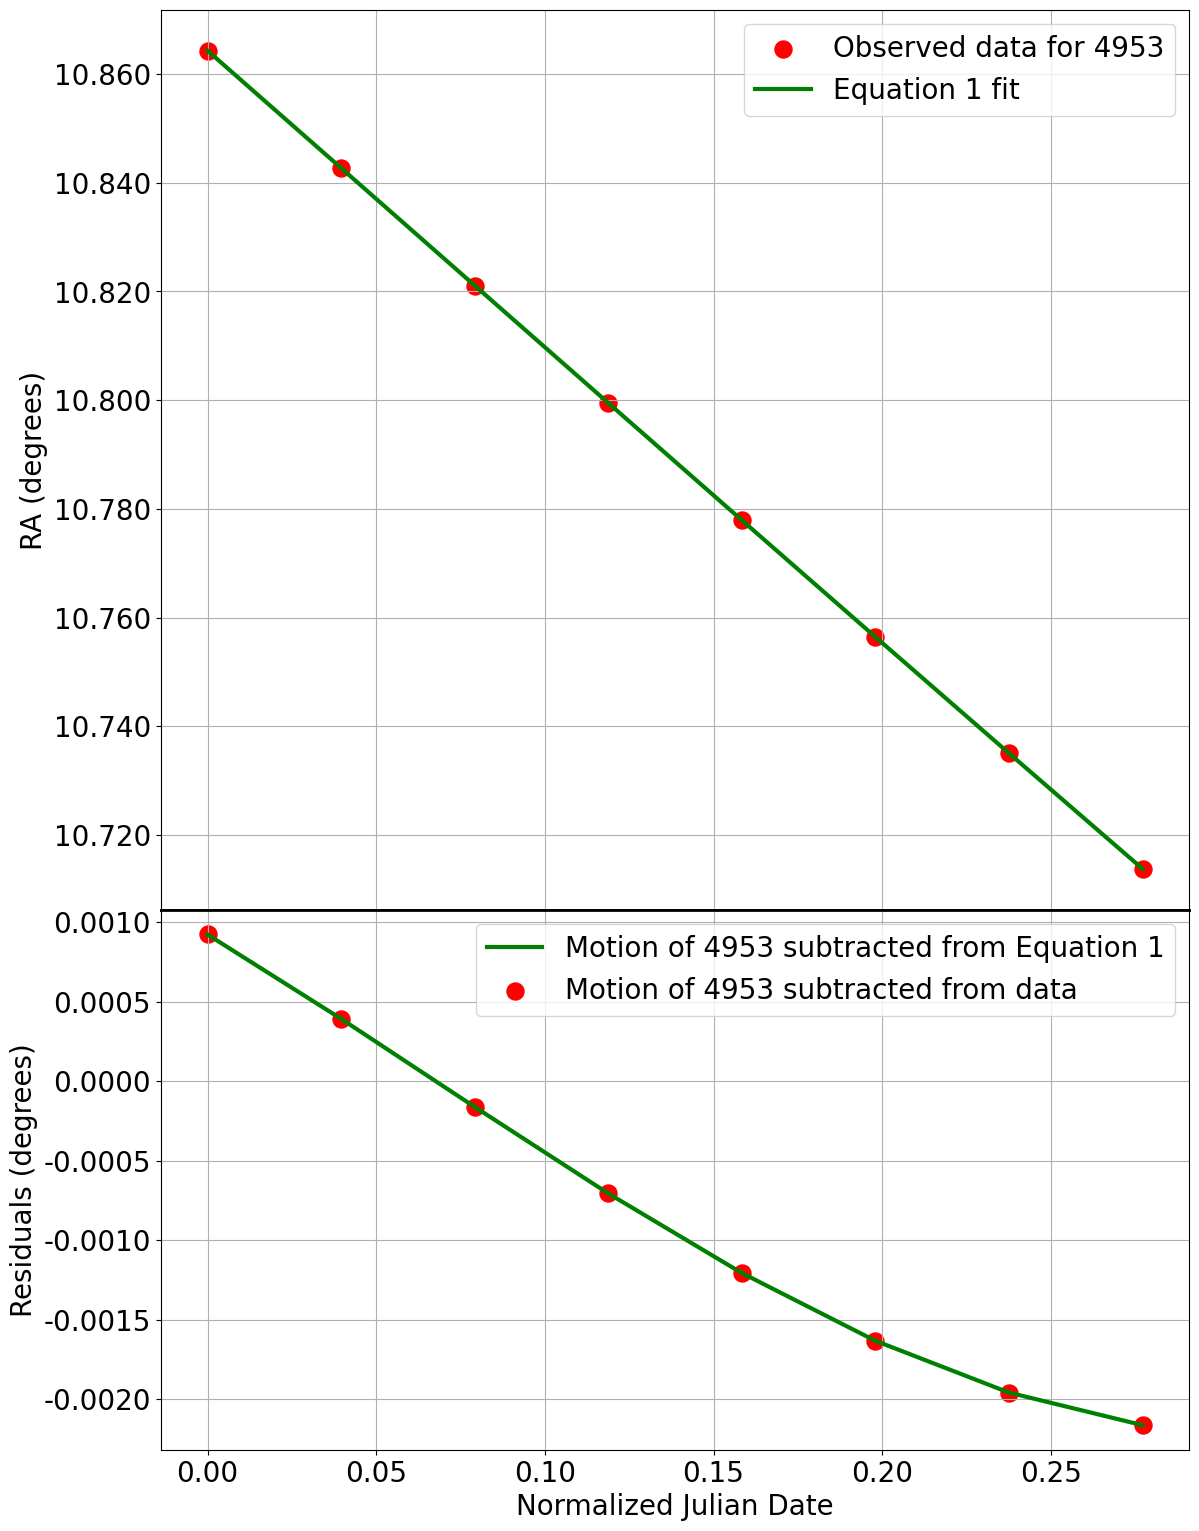

In [13]:
fig = plt.figure(figsize=(12.1, 18))
gs = GridSpec(3, 1, height_ratios=[10, 6, 1], figure=fig)

# Subplot 1: 
ax1 = fig.add_subplot(gs[0, 0])

ax1.scatter(jd_binned_median, ra_deg_adjusted_detected, color='red', label = 'Observed data for 4953', s = 150)
ax1.plot(jd_binned_median, fit_function_linear(jd_binned_median, *params_sine), color='green', label = 'Equation 1 fit', linewidth = 3)

ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_ylabel("RA (degrees)", fontsize=20)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.set_xticklabels([])
ax1.legend(fontsize=20)
ax1.grid()

# Subplot 2: 
ax2 = fig.add_subplot(gs[1, 0])

ax2.plot(jd_binned_median, 
         fit_function_linear(jd_binned_median, *params_sine) - (params_sine[2]*jd_binned_median + params_sine[3]), 
         color = 'green', label = 'Motion of 4953 subtracted from Equation 1', linewidth = 3)
ax2.scatter(jd_binned_median, ra_deg_adjusted_detected - (params_sine[2]*jd_binned_median + params_sine[3]), 
            color = 'red', label = 'Motion of 4953 subtracted from data', s = 150)

ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel("Normalized Julian Date", fontsize=20)
ax2.set_ylabel("Residuals (degrees)", fontsize=20) 
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax2.legend(fontsize=20)
ax2.grid()

plt.subplots_adjust(hspace=0)
plt.gcf().axes[0].spines['bottom'].set_linewidth(2)
plt.gcf().axes[1].spines['top'].set_linewidth(2)

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.1, hspace=0)
plt.savefig("Figure 7.png", format="png", dpi=300, bbox_inches="tight", facecolor='white')

plt.show()

##### Step 14: Retesting the results as per the exact equations seen in 3 and 4 in the manuscript. 

In [14]:
Dec      = dec_rad
latitude = latitude_rad
Am       = amplitude_rad
Am_sigma = amplitude_uncertainty_rad

# Uncertainties in the final distance measurement is error propogated through a standard first-order Gaussian.

# ---------- Eq. 3: --------------------------------
# The Projected Parallax amplitude and uncertainty
# If Ap is large, the distance is well-constained and the object is closer to the observer, and vice versa

Ap               = (math.cos(Dec)/math.cos(latitude))*Am
Ap_uncertainties = (math.cos(Dec)/math.cos(latitude))*Am_sigma
print(Ap)
print(Ap_uncertainties)
print(f"\033[1;32mAp: {abs(Ap):.6f} ± {abs(Ap_uncertainties):.6f}\033[0m")

# ---------- Eq. 4: --------------------------------
# The asteroids distance is inverse proportional to the parallax amplitude
Asteroid_Distance_km               = earth_radius_km                     /Ap

# and the uncertainty is   ==>   σ_D = |∂D/∂Ap| * σ_Ap   ==>    σ_D = R_earth * σ_Ap / Ap^2 
Asteroid_Distance_km_uncertainties = earth_radius_km * Ap_uncertainties / (Ap**2) 

print(Asteroid_Distance_km)
print(Asteroid_Distance_km_uncertainties)
print(f"\033[1;32mAsteroid Distance (km): {abs(Asteroid_Distance_km):.6f} ± {abs(Asteroid_Distance_km_uncertainties):.6f}\033[0m")

# ---------- Distance (au) ------------------------
Asteroid_Distance_au               = Asteroid_Distance_km              /km_to_au
Asteroid_Distance_au_uncertainties = Asteroid_Distance_km_uncertainties/km_to_au
print(Asteroid_Distance_au)
print(Asteroid_Distance_au_uncertainties)
print(f"\033[1;32mAsteroid Distance (km): {abs(Asteroid_Distance_au):.6f} ± {abs(Asteroid_Distance_au_uncertainties):.6f}\033[0m")

# ---------- % difference -------------------------
if asteroid_dist_au == 0 or true_distance == 0:
    print("\033[1;31mError: One of the values is zero, cannot compute percentage difference.\033[0m")
else:
    percentage_difference = abs(abs(Asteroid_Distance_au) - abs(true_distance)) / ((abs(Asteroid_Distance_au) + abs(true_distance)) / 2) * 100
    print(f"\033[1;32mHorizons versus Measured: {percentage_difference:.2f}%\033[0m")

-3.617291044459589e-05
7.825658289559376e-07
Ap: 0.000036 ± 0.000001
-176126275.75981534
3810321.129730752
Asteroid Distance (km): 176126275.759815 ± 3810321.129731
-1.1773314348371628
0.025470423555505543
Asteroid Distance (km): 1.177331 ± 0.025470
Horizons versus Measured: 2.62%


##### FINAL SUMMARY: Topocentric Parallax distance measurement for Asteroid 4953

In [15]:
# 1. Fit parameters from Equation 1
print("=== Fit Parameters from Equation 1 ===")
parameter_names = ["Am (deg)", "B", "C", "D"]
for name, value, error in zip(parameter_names, params_sine, sine_uncertainties):
    print(f"{name:<10}: {value:.6e} ± {error:.6e}")

# 2. Parallax amplitude in radians
print("\n=== Parallax Amplitude ===")
print(f"Am (rad): {amplitude_rad:.6e} ± {amplitude_uncertainty_rad:.6e}")

# 3. Distance results
print("\n=== Distance to Asteroid 4953/1990 MU ===")
print(f"Distance:    {abs(asteroid_km):.2f} km   ({abs(asteroid_dist_au):.6f} au)")
print(f"Uncertainty: ± {abs(asteroid_uncertainty_km):.2f} km  (± {abs(asteroid_dist_uncertainty_au):.6f} au)")

# 4. Percentage Difference
print("\n=== Difference comparism with Horizons mean distance ===")
print(f"Percentage: {abs(percentage_difference):.2f} %")


# 4. Summary Text
summary_text = """ 
Summary:
--------
We input data of asteroid 4953 from NASA JPL Horizons System on October 31, 2024, totalling 1049 
observations taken at six different times over a single night. We fit Equation 1 in the manuscript, 
which connects the Earth's rotation with the linear motion of the asteroid 
to the RA time series of observations. 

The best-fit sinusoidal amplitude (Am) and its 1σ uncertainty were converted 
to radians and used in Equations 3 and 4 of the manuscript to compute the 
distance to asteroid 4953. The resulting distance and uncertainties are consistent 
with expectations for an object at this geometry and validate that the topocentric parallax 
method is implemented correctly. This confirms that the entire analysis pipeline is 
functioning as described in the manuscript.
"""
print("\n" + summary_text)


=== Fit Parameters from Equation 1 ===
Am (deg)  : -2.236091e-03 ± 4.837567e-05
B         : -6.708001e+00 ± 1.086576e-02
C         : -5.320684e-01 ± 3.051834e-04
D         : 1.086340e+01 ± 4.291217e-05

=== Parallax Amplitude ===
Am (rad): -3.902716e-05 ± 8.443147e-07

=== Distance to Asteroid 4953/1990 MU ===
Distance:    176126275.76 km   (1.177331 au)
Uncertainty: ± 3810321.13 km  (± 0.025470 au)

=== Difference comparism with Horizons mean distance ===
Percentage: 2.62 %

 
Summary:
--------
We input data of asteroid 4953 from NASA JPL Horizons System on October 31, 2024, totalling 1049 
observations taken at six different times over a single night. We fit Equation 1 in the manuscript, 
which connects the Earth's rotation with the linear motion of the asteroid 
to the RA time series of observations. 

The best-fit sinusoidal amplitude (Am) and its 1σ uncertainty were converted 
to radians and used in Equations 3 and 4 of the manuscript to compute the 
distance to asteroid 4953. The